In [2]:
from threeDrebuild.connect import get_lines
from threeDrebuild.cluster import cluster_lines
from threeDrebuild.create_3d_point import generate_3d_points
from threeDrebuild.threedv_3dline import generate_3d_lines,make_map
from threeDrebuild.draw3d_lines import draw_3d_model

lines, line_map,acad = get_lines()

# for line in lines:
#     print(line)

clusters = cluster_lines(lines, expand_distance=5)

# 输出结果
# for i, cluster in enumerate(clusters):
#     print(f"Cluster {i+1}:")
#     print(f"  min_x: {cluster.min_x}, max_x: {cluster.max_x}")
#     print(f"  min_y: {cluster.min_y}, max_y: {cluster.max_y}")
#     print(f"  length_x: {cluster.length_x}, length_y: {cluster.length_y}")
#     print("  Lines:")
#     for line in cluster.lines:
#         print(f"    {line}")

result = generate_3d_points(clusters)

# # 输出结果
# print("主视图线段：", result["front_lines"])
# print("顶视图线段：", result["top_lines"])
# print("右视图线段：", result["right_lines"])
# print("3D点集合：", result["points_3d"])

line3d= generate_3d_lines(result["points_3d"], result["front_lines"], result["top_lines"], result["right_lines"],result["front_points"], result["top_points"], result["right_points"])

#print(line3d)
# 获取聚类的最小x和y值

cluster_min_x_r =clusters[2].min_x 
cluster_min_y_t =clusters[1] .min_y 


# 绘制3D模型
lines,arcs,circles=draw_3d_model(acad,line3d, line_map, cluster_min_x_r, cluster_min_y_t)


其他对象: AcDbRotatedDimension
其他对象: AcDbRotatedDimension
其他对象: AcDbRotatedDimension
其他对象: AcDbRotatedDimension
其他对象: AcDb2LineAngularDimension
主视图有 90 条线段，32 个点
顶视图有 100 条线段，48 个点
右视图有 102 条线段，40 个点
3D点生成完毕，共 104 个点


'图中共有 4 个连通分量'

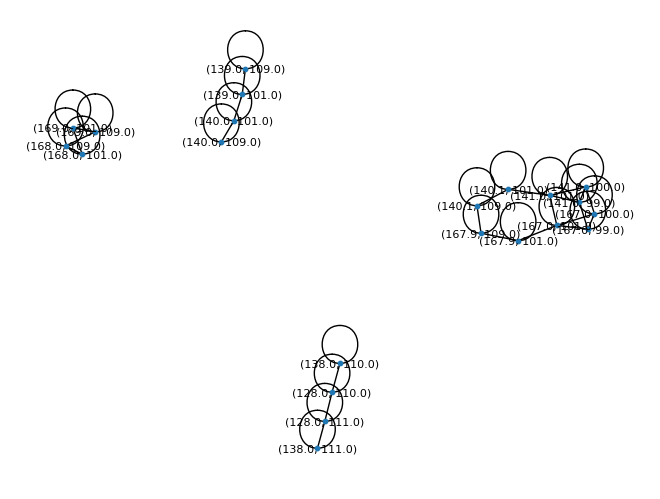

In [8]:
from unfold.build_graph import get_graph
import importlib
from unfold import build_compoment
importlib.reload(build_compoment)  # 强制重新加载模块
from unfold.build_compoment import get_component
G_without_arcs,centermap=get_graph(lines,arcs)
get_component(G_without_arcs)